# Сверточная нейронная сеть (CNN) для классификации MNIST на GPU

Этот ноутбук демонстрирует реализацию сверточной нейронной сети (CNN) для классификации рукописных цифр из набора данных MNIST, оптимизированную для работы на GPU в Google Colab. Мы используем `ipywidgets` для интерактивной настройки гиперпараметров, визуализацию карт активации, интерактивную матрицу ошибок с `plotly` и анализ ошибок классификации.

**Примечание:** Код оптимизирован для работы на GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import plotly.express as px
from ipywidgets import interact, IntSlider, Dropdown
import pandas as pd

# Зафиксируем seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

# Проверка доступности GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU detected: {gpus[0].name}')
else:
    print('No GPU detected, running on CPU')

GPU detected: /physical_device:GPU:0


## 1. Загрузка и предобработка данных MNIST

Загружаем набор данных MNIST, нормализуем значения пикселей (0-255 -> 0-1), изменяем форму данных для CNN и преобразуем метки в категориальный формат.

In [2]:
# Загрузка и предобработка данных MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Нормализация данных (0-255 -> 0-1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Изменение формы для CNN (добавляем канал для черно-белых изображений)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Преобразование меток в категориальный формат
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 2. Создание модели CNN

Определяем архитектуру CNN с двумя сверточными слоями, пулинг-слоями, слоем Flatten, плотным слоем с Dropout и выходным слоем для классификации 10 классов.

In [3]:
# Создание модели CNN
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
        MaxPooling2D((2, 2), name='pool1'),
        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        MaxPooling2D((2, 2), name='pool2'),
        Flatten(),
        Dense(128, activation='relu', name='dense1'),
        Dropout(0.5),
        Dense(10, activation='softmax', name='output')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3. Интерактивное обучение модели

Используем виджеты для выбора количества эпох и размера батча. Модель обучается на GPU с использованием массивов NumPy.

In [4]:
# Определение функции обучения
def train_model(epochs, batch_size):
    global model, history
    model = create_model()  # Создаем новую модель для каждого запуска
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, verbose=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'\nТочность на тестовом наборе: {test_accuracy:.4f}')

In [5]:
# Интерактивный вызов функции
from ipywidgets import interact, IntSlider, Dropdown
@interact(epochs=IntSlider(min=1, max=20, step=1, value=10),
          batch_size=Dropdown(options=[32, 64, 128, 256], value=128))
def interactive_train(epochs, batch_size):
    train_model(epochs, batch_size)

interactive(children=(IntSlider(value=10, description='epochs', max=20, min=1), Dropdown(description='batch_si…

## 4. Визуализация фильтров первого сверточного слоя

Визуализируем фильтры первого сверточного слоя, чтобы показать, какие шаблоны модель изучает.

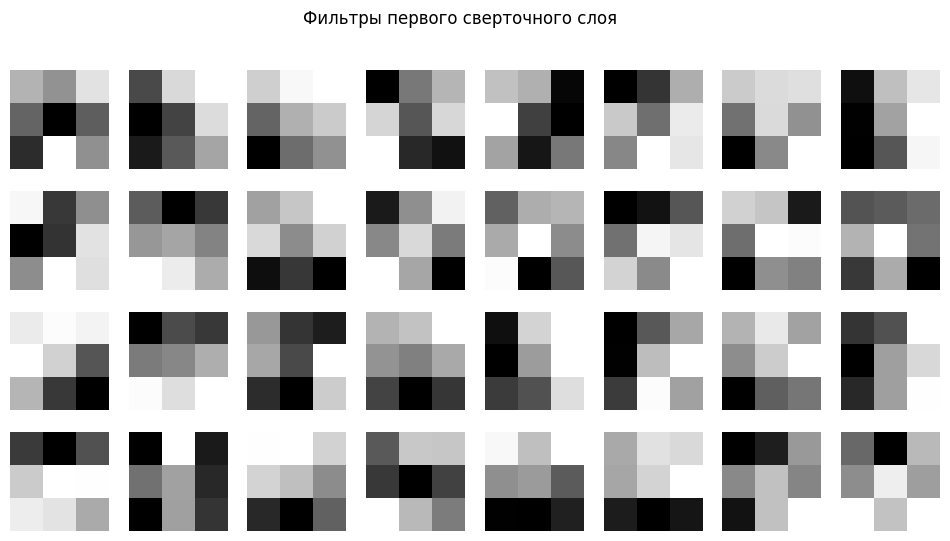

In [6]:
# Визуализация фильтров первого сверточного слоя
filters, biases = model.get_layer('conv1').get_weights()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('Фильтры первого сверточного слоя')
for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(filters[:, :, 0, i], cmap='gray')
    ax.axis('off')
plt.show()

## 5. Графики точности и потерь

Графики показывают изменение точности и потерь на тренировочных и валидационных данных.

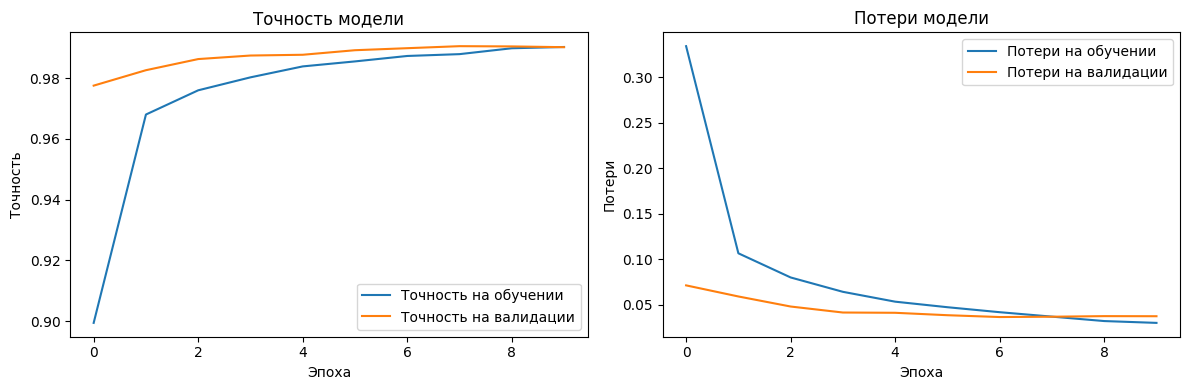

In [8]:
# Графики точности и потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Интерактивная матрица ошибок

Создаем интерактивную матрицу ошибок с помощью Plotly для более удобного анализа.

In [9]:
# Матрица ошибок
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# Интерактивная матрица ошибок с Plotly
fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues',
                labels=dict(x='Предсказанный класс', y='Истинный класс', color='Количество'),
                title='Интерактивная матрица ошибок')
fig.update_xaxes(side='top')
fig.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## 7. Анализ ошибок классификации

Визуализируем изображения, которые модель классифицировала неверно.

In [10]:
@interact(num_samples=IntSlider(min=1, max=20, step=1, value=10))
def visualize_misclassifications(num_samples):
    incorrect_indices = np.where(y_pred_classes != y_true)[0]
    num_samples = min(num_samples, len(incorrect_indices))

    plt.figure(figsize=(15, 3 * num_samples // 5 + 1))
    plt.suptitle('Неверно классифицированные изображения')
    for i, idx in enumerate(incorrect_indices[:num_samples]):
        plt.subplot(num_samples // 5 + 1, 5, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Предсказано: {y_pred_classes[idx]}\nИстинное: {y_true[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='num_samples', max=20, min=1), Output()), _dom_classes=(…

## 8. Интерактивное предсказание для выбранного изображения

Выберите индекс тестового изображения, чтобы увидеть предсказание модели и распределение вероятностей.

In [11]:
@interact(image_idx=IntSlider(min=0, max=len(X_test)-1, step=1, value=0))
def predict_image(image_idx):
    pred = model.predict(X_test[image_idx:image_idx+1])
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = y_true[image_idx]

    # Визуализация изображения
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[image_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Предсказано: {pred_class}\nИстинное: {true_class}')
    plt.axis('off')

    # Визуализация вероятностей
    plt.subplot(1, 2, 2)
    plt.bar(range(10), pred[0])
    plt.title('Вероятности классов')
    plt.xlabel('Класс')
    plt.ylabel('Вероятность')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image_idx', max=9999), Output()), _dom_classes=('widget-…

## 9. Интерактивное рисование и предсказание

Нарисуйте цифру мышью на канвасе, нажмите \"Предсказать\", чтобы получить предсказание модели. Показаны предсказанный класс, уверенность и топ-3 вероятности.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


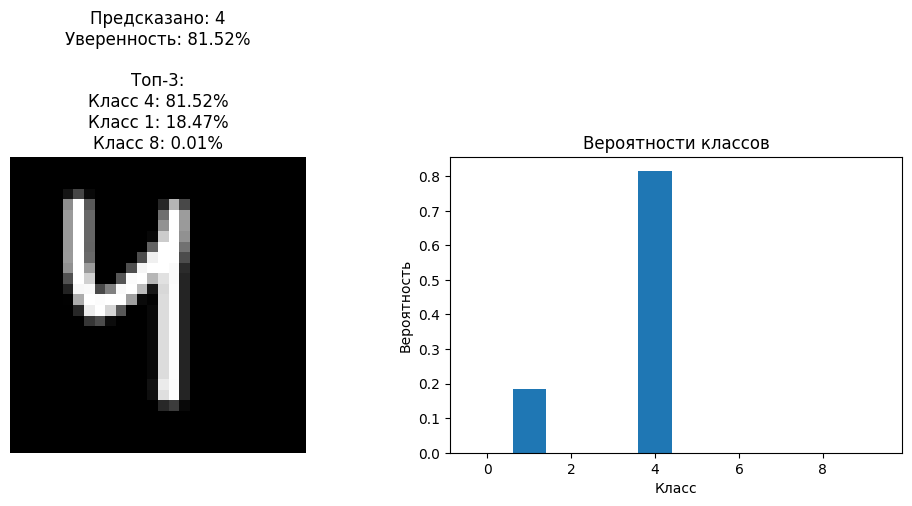

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


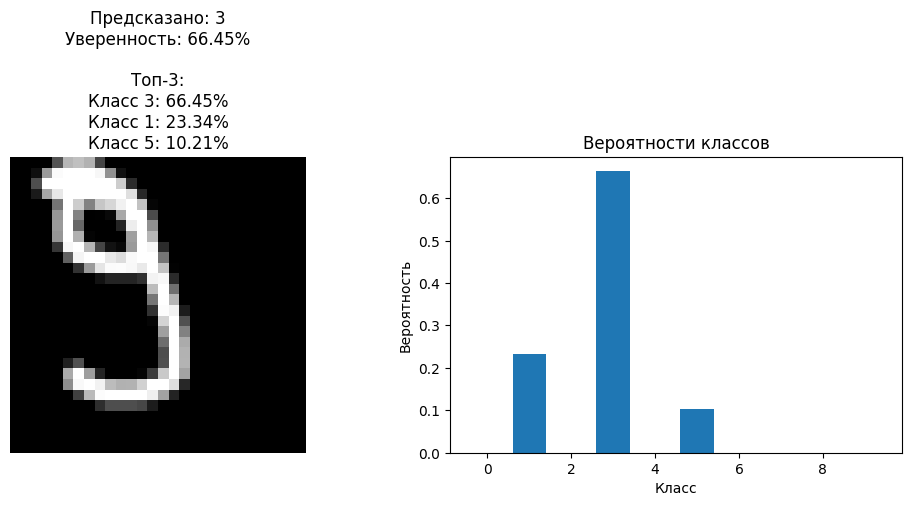

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


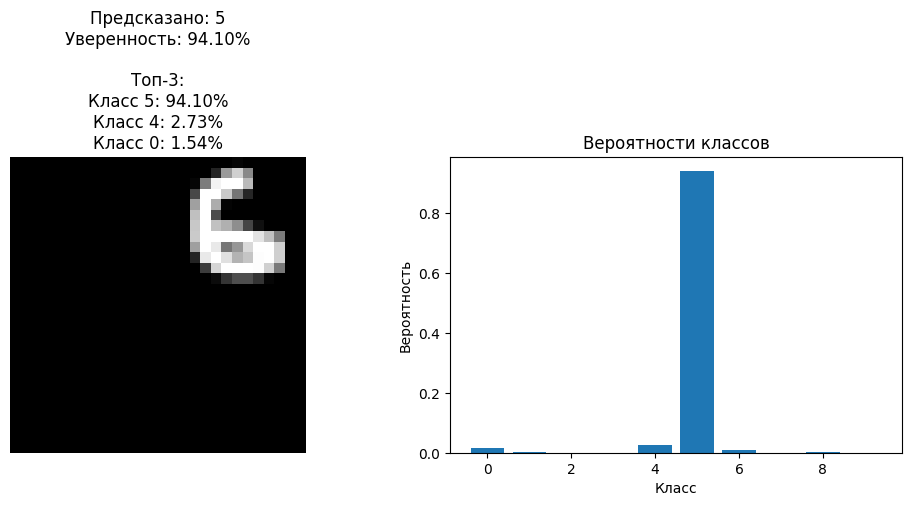

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image
from IPython.display import HTML, display
from google.colab import output

# HTML/JavaScript для рисования
canvas_html = """
<canvas id='canvas' width='280' height='280' style='border:2px solid black;'></canvas>
<br>
<button onclick='clearCanvas()'>Очистить</button>
<button onclick='predict()'>Предсказать</button>
<script>
var canvas = document.getElementById('canvas');
var ctx = canvas.getContext('2d');
ctx.fillStyle = 'black';
ctx.fillRect(0, 0, canvas.width, canvas.height);
ctx.strokeStyle = 'white';
ctx.lineWidth = 20;
ctx.lineCap = 'round';
var drawing = false;

canvas.addEventListener('mousedown', function(e) {
    drawing = true;
    ctx.beginPath();
    ctx.moveTo(e.offsetX, e.offsetY);
});

canvas.addEventListener('mousemove', function(e) {
    if (drawing) {
        ctx.lineTo(e.offsetX, e.offsetY);
        ctx.stroke();
    }
});

canvas.addEventListener('mouseup', function() {
    drawing = false;
    ctx.closePath();
});

function clearCanvas() {
    ctx.fillStyle = 'black';
    ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function predict() {
    var dataURL = canvas.toDataURL('image/png');
    google.colab.kernel.invokeFunction('notebook.predict', [dataURL], {});
}
</script>
"""

# Отображаем канвас
display(HTML(canvas_html))

# Функция для обработки изображения и предсказания
def predict_drawing(data_url):
    # Декодируем base64 изображение
    img_data = base64.b64decode(data_url.split(',')[1])
    img = Image.open(io.BytesIO(img_data)).convert('L')  # Конвертируем в grayscale
    img = img.resize((28, 28))  # Изменяем размер до 28x28
    img_array = np.array(img) / 255.0  # Нормализация
    img_array = img_array.reshape(1, 28, 28, 1)  # Формат для модели

    # Предсказание
    # Убедитесь, что ваша модель (например, 'model') загружена и доступна
    # Например, если вы использовали модель из предыдущих шагов:
    # from tensorflow.keras.models import load_model
    # model = load_model('путь_к_вашей_модели.h5') # Или используйте модель, обученную в предыдущих ячейках
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred) * 100

    # Топ-3 класса
    top3_indices = np.argsort(pred[0])[-3:][::-1]
    top3_probs = pred[0][top3_indices] * 100
    top3_text = '\n'.join([f'Класс {idx}: {prob:.2f}%' for idx, prob in zip(top3_indices, top3_probs)])

    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.title(f'Предсказано: {pred_class}\nУверенность: {confidence:.2f}%\n\nТоп-3:\n{top3_text}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(range(10), pred[0])
    plt.title('Вероятности классов')
    plt.xlabel('Класс')
    plt.ylabel('Вероятность')
    plt.tight_layout()
    plt.show()

# Регистрируем функцию для вызова из JavaScript
output.register_callback('notebook.predict', predict_drawing)